In [1]:
import statistics as st
import warnings

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg

warnings.filterwarnings("ignore")

In [2]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "regr_model_two_means"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%config InlineBackend.figure_format = "retina"

In [3]:
kidiq = pd.read_stata("../data/kidiq.dta")
kidiq.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1.0,121.117529,4,27
1,98,1.0,89.361882,4,25
2,85,1.0,115.443165,4,27
3,83,1.0,99.449639,3,25
4,115,1.0,92.745710,4,27


In [4]:
kidiq.groupby(["mom_hs"]).size()

mom_hs
0.0     93
1.0    341
dtype: int64

In [5]:
summary_stats = [st.mean, st.stdev]
kidiq.groupby(["mom_hs"]).aggregate(summary_stats)

kid_score                 mom_iq             mom_work            \
             mean      stdev        mean      stdev      mean     stdev   
mom_hs                                                                    
0.0     77.548387  22.573800   91.889152  12.630498  2.322581  1.226175   
1.0     89.319648  19.049483  102.212049  14.848414  3.052786  1.120727   

          mom_age            
             mean     stdev  
mom_hs                       
0.0     21.677419  2.727323  
1.0     23.087977  2.617453

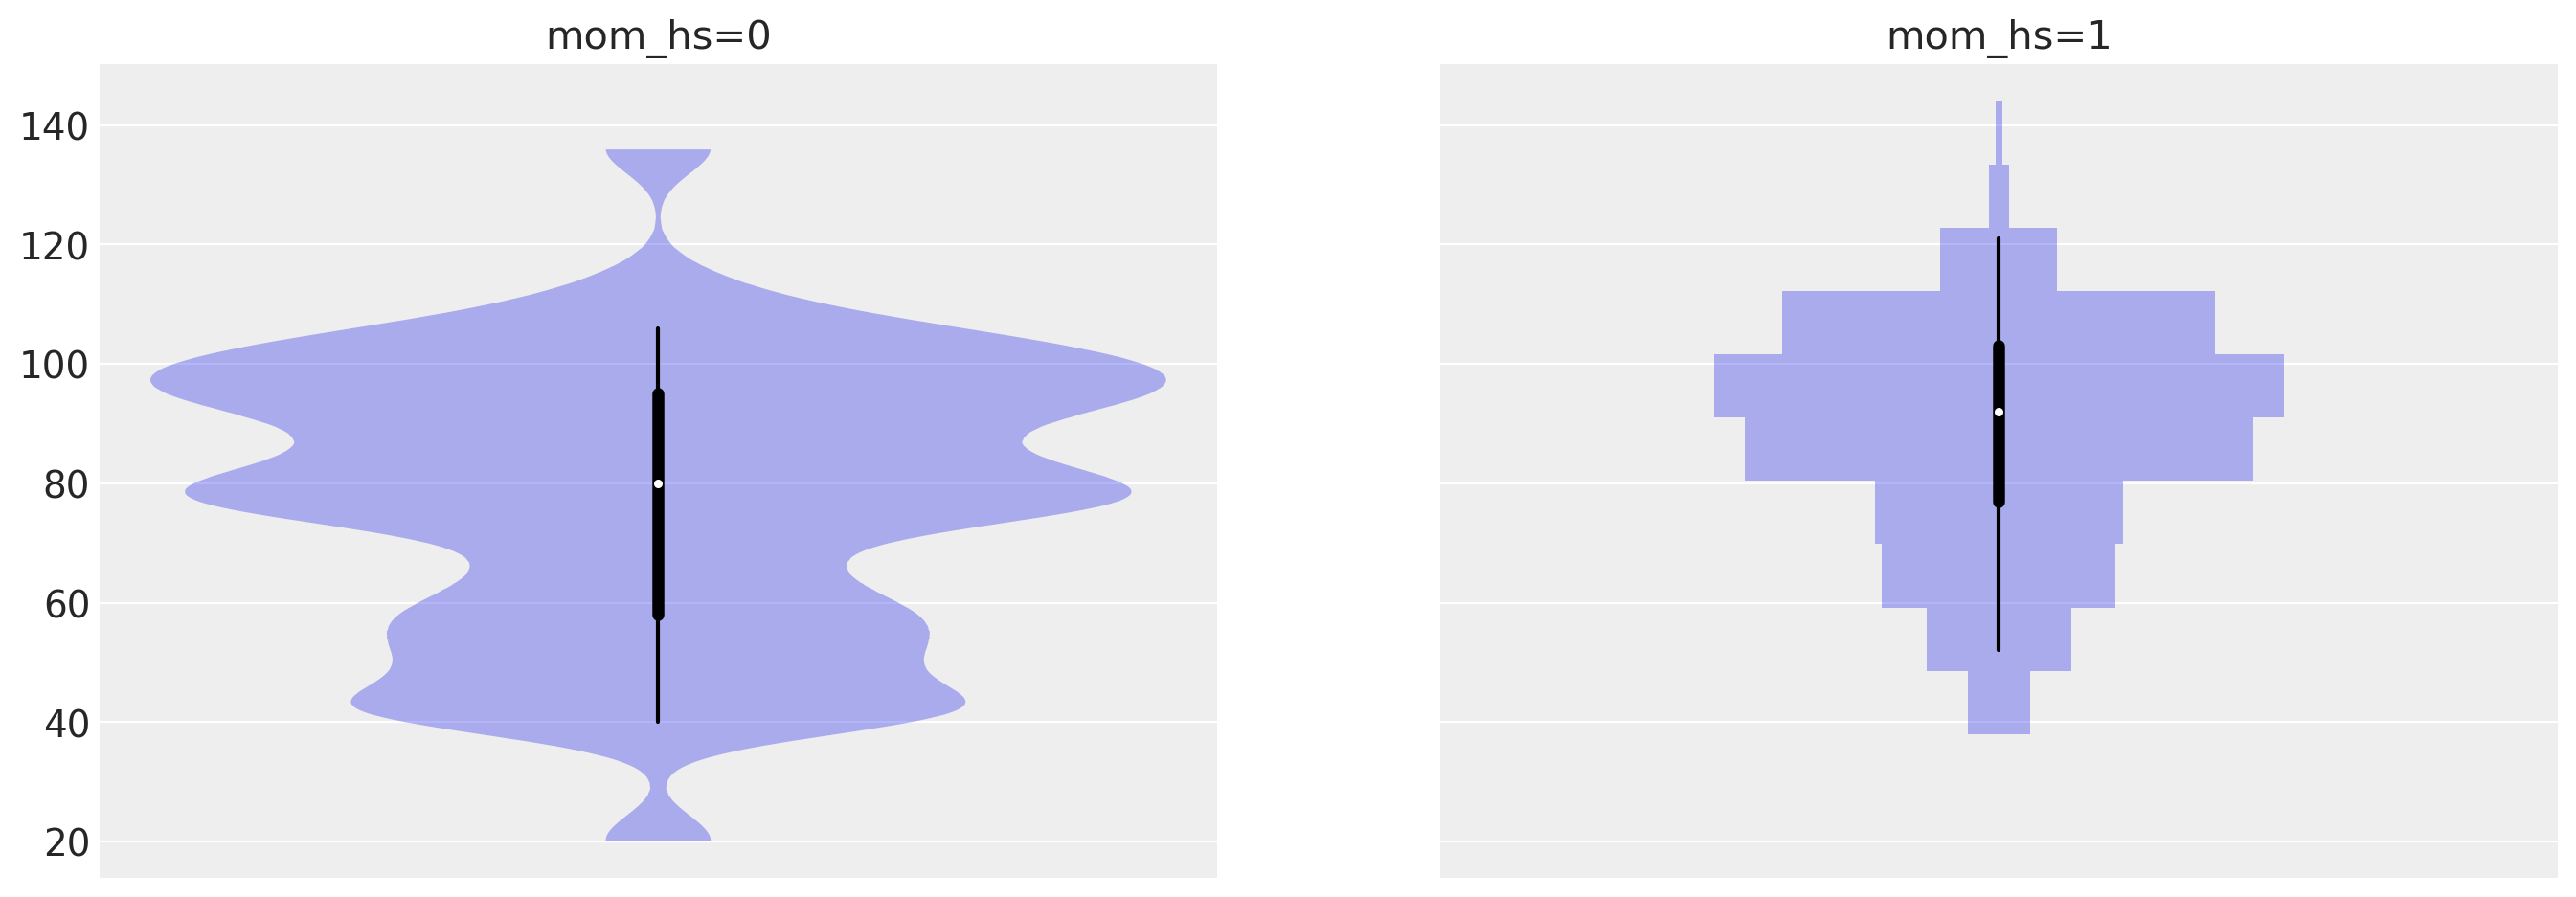

In [6]:
az.plot_violin(
    {
        "mom_hs=0": kidiq.loc[kidiq.mom_hs == 0, "kid_score"],
        "mom_hs=1": kidiq.loc[kidiq.mom_hs == 1, "kid_score"],
    }
);

In [7]:
mod = bmb.Model("kid_score ~ mom_hs", kidiq)

In [8]:
results = mod.fit(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [9]:
mod

       Formula: kid_score ~ mom_hs
        Family: gaussian
          Link: mu = identity
  Observations: 434
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 86.7972, sigma: 110.1032)
            mom_hs ~ Normal(mu: 0.0, sigma: 124.2132)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 20.3872)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Sampling: [Intercept, kid_score_sigma, mom_hs]


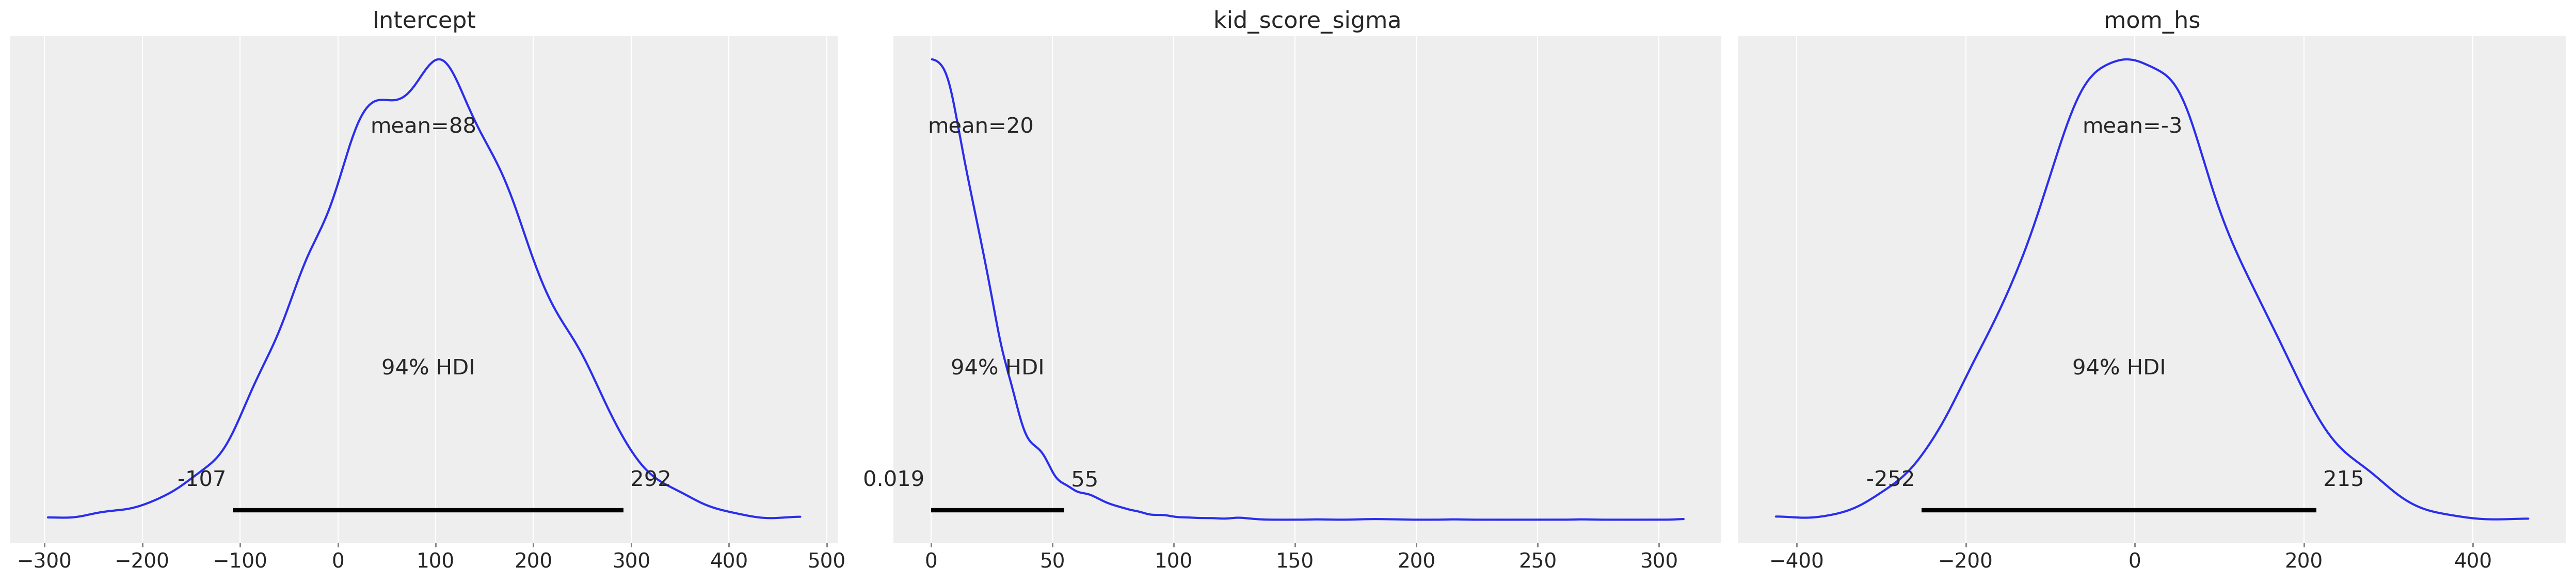

In [10]:
_ = mod.plot_priors()

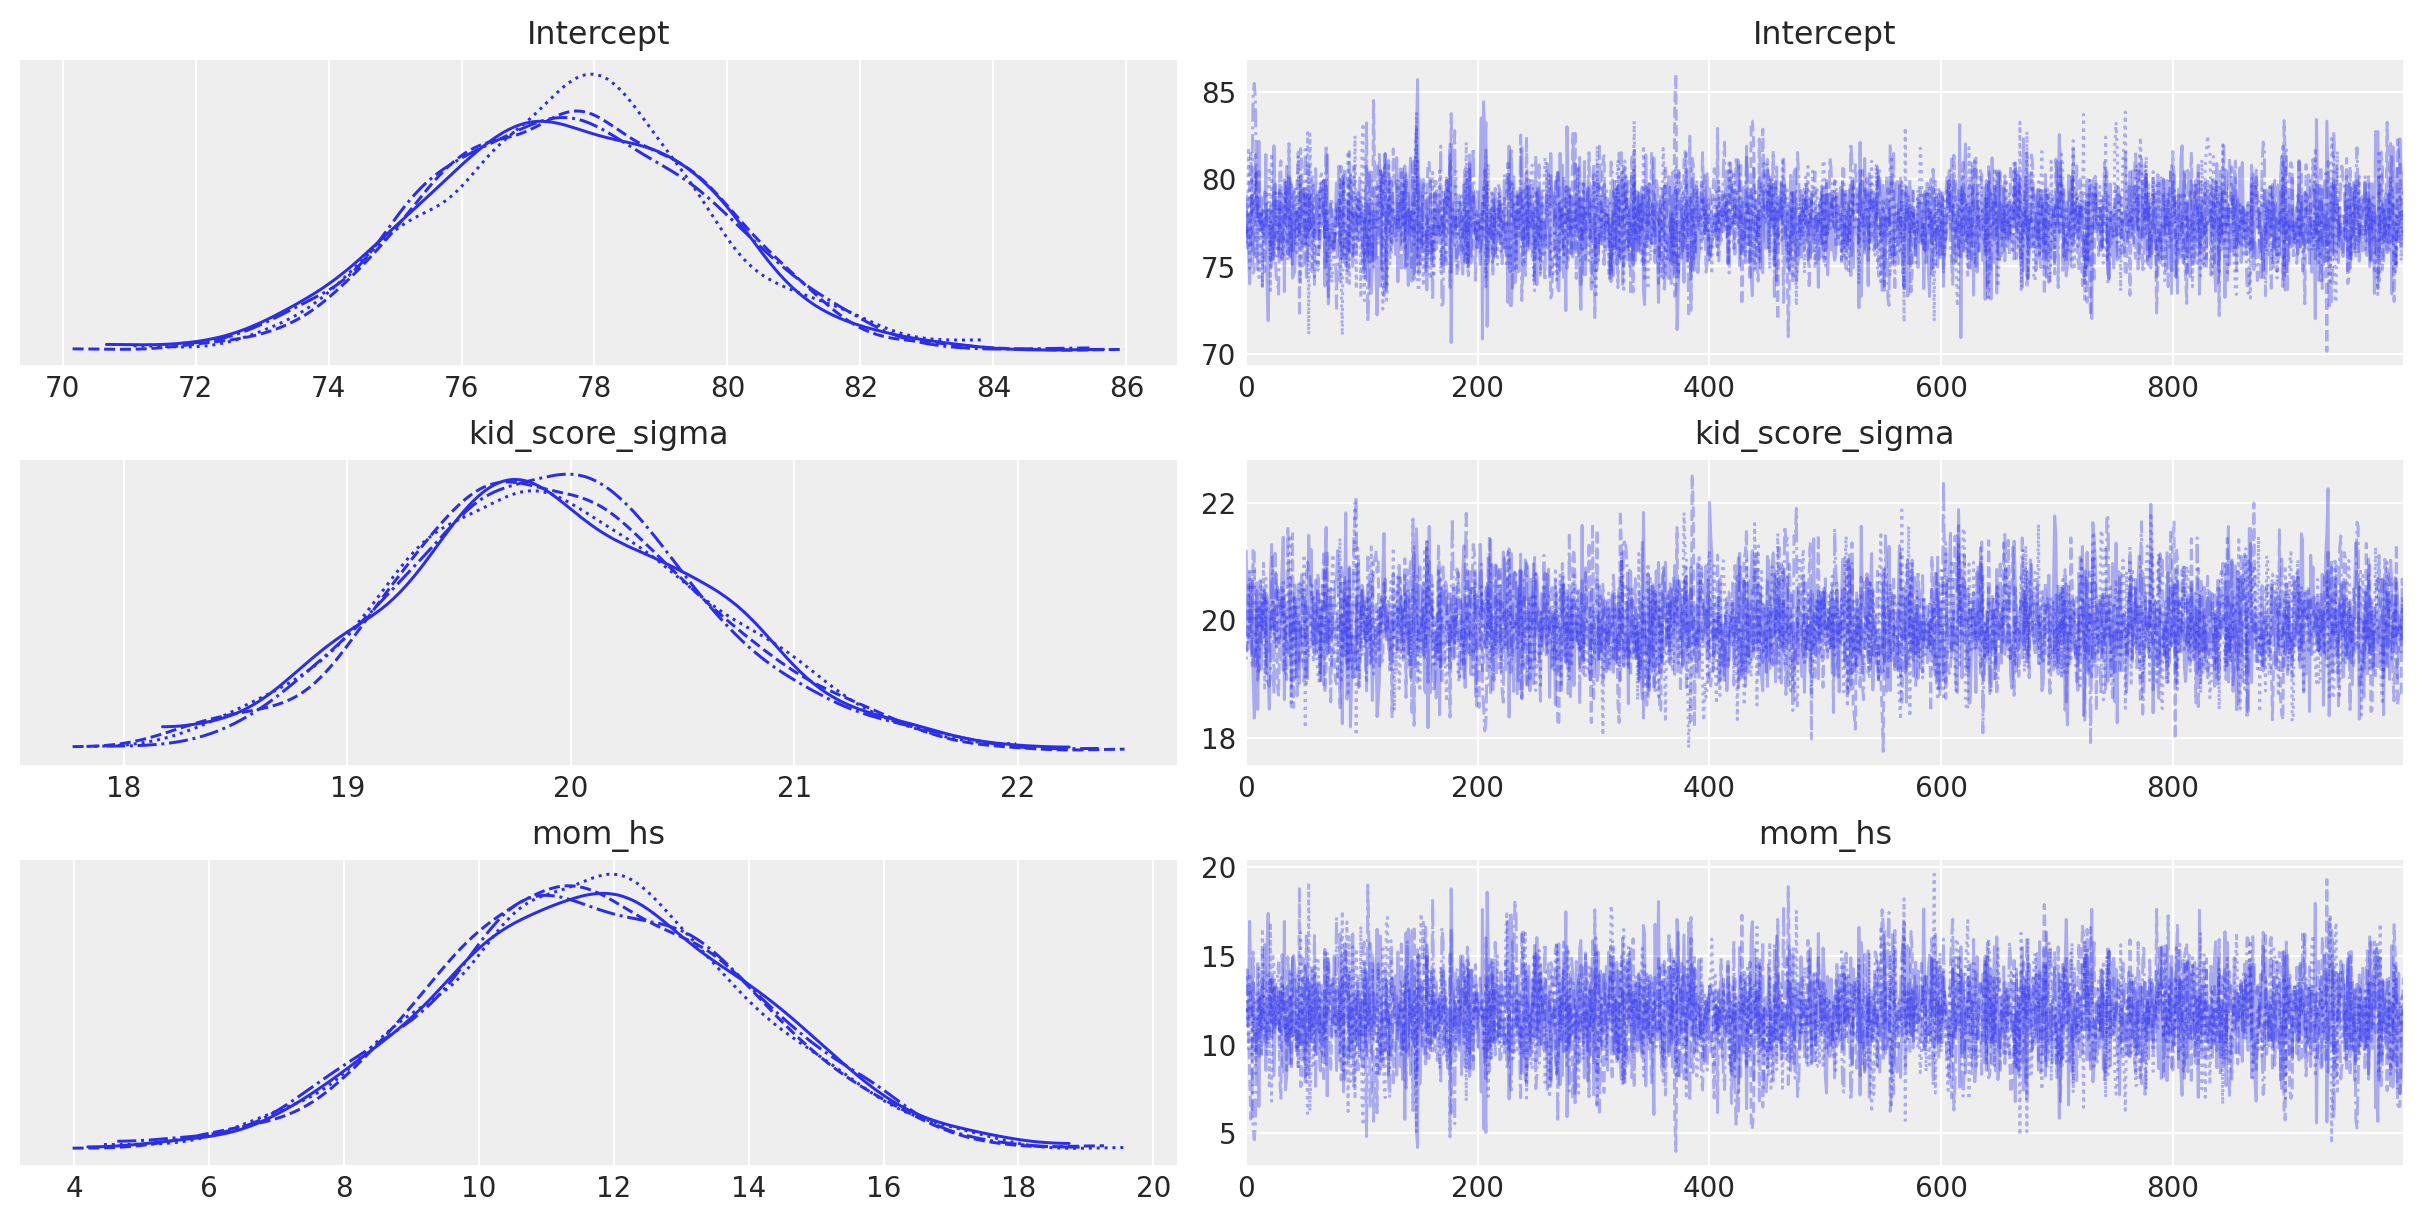

In [11]:
_ = az.plot_trace(results)

In [12]:
az.summary(results, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,77.60,2.10,73.76,81.57,0.03,0.02,4184.05,2952.91,1.0
kid_score_sigma,19.92,0.69,18.55,21.19,0.01,0.01,3954.72,2873.71,1.0
mom_hs,11.69,2.34,7.27,16.02,0.04,0.03,4304.88,2792.27,1.0


In [13]:
lm = pg.linear_regression(kidiq["mom_hs"], kidiq["kid_score"])
lm.round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,77.55,2.06,37.67,0.0,0.06,0.05,73.50,81.59
1,mom_hs,11.77,2.32,5.07,0.0,0.06,0.05,7.21,16.34


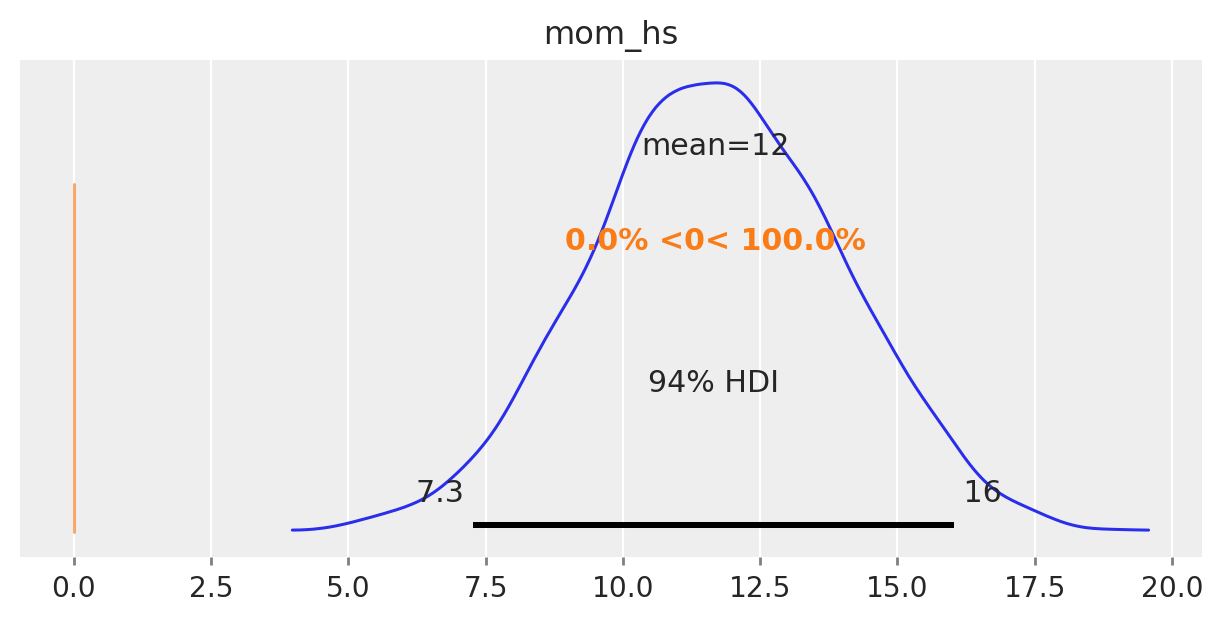

In [14]:
az.plot_posterior(results, var_names="mom_hs", ref_val=0, figsize=(6, 3));

In [15]:
results.posterior

<xarray.Dataset> Size: 104kB
Dimensions:          (chain: 4, draw: 1000)
Coordinates:
  * chain            (chain) int64 32B 0 1 2 3
  * draw             (draw) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
Data variables:
    Intercept        (chain, draw) float64 32kB 78.58 77.08 ... 79.21 76.52
    kid_score_sigma  (chain, draw) float64 32kB 21.18 19.7 20.55 ... 19.73 19.83
    mom_hs           (chain, draw) float64 32kB 11.91 11.08 ... 11.37 11.91
Attributes:
    created_at:                  2024-06-16T07:47:48.798315+00:00
    arviz_version:               0.18.0
    modeling_interface:          bambi
    modeling_interface_version:  0.13.0

In [16]:
# Probabiliy that posterior is > 0
(results.posterior["mom_hs"] > 0).mean().item()

1.0

In [17]:
# Add a new column 'hs' with the categories based on 'mom_hs'
kidiq["hs"] = kidiq["mom_hs"].map({0: "not_completed", 1: "completed"})
kidiq.tail()

,kid_score,mom_hs,mom_iq,mom_work,mom_age,hs
429,94,0.0,84.877412,4,21,not_completed
430,76,1.0,92.990392,4,23,completed
431,50,0.0,94.859708,2,24,not_completed
432,88,1.0,96.856624,2,21,completed
433,70,1.0,91.253336,2,25,completed


In [18]:
mod_2 = bmb.Model("kid_score ~ 0 + hs", kidiq)
results_2 = mod_2.fit(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [19]:
mod_2

       Formula: kid_score ~ 0 + hs
        Family: gaussian
          Link: mu = identity
  Observations: 434
        Priors: 
    target = mu
        Common-level effects
            hs ~ Normal(mu: [0. 0.], sigma: [124.2132 124.2132])
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 20.3872)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Sampling: [hs, kid_score_sigma]


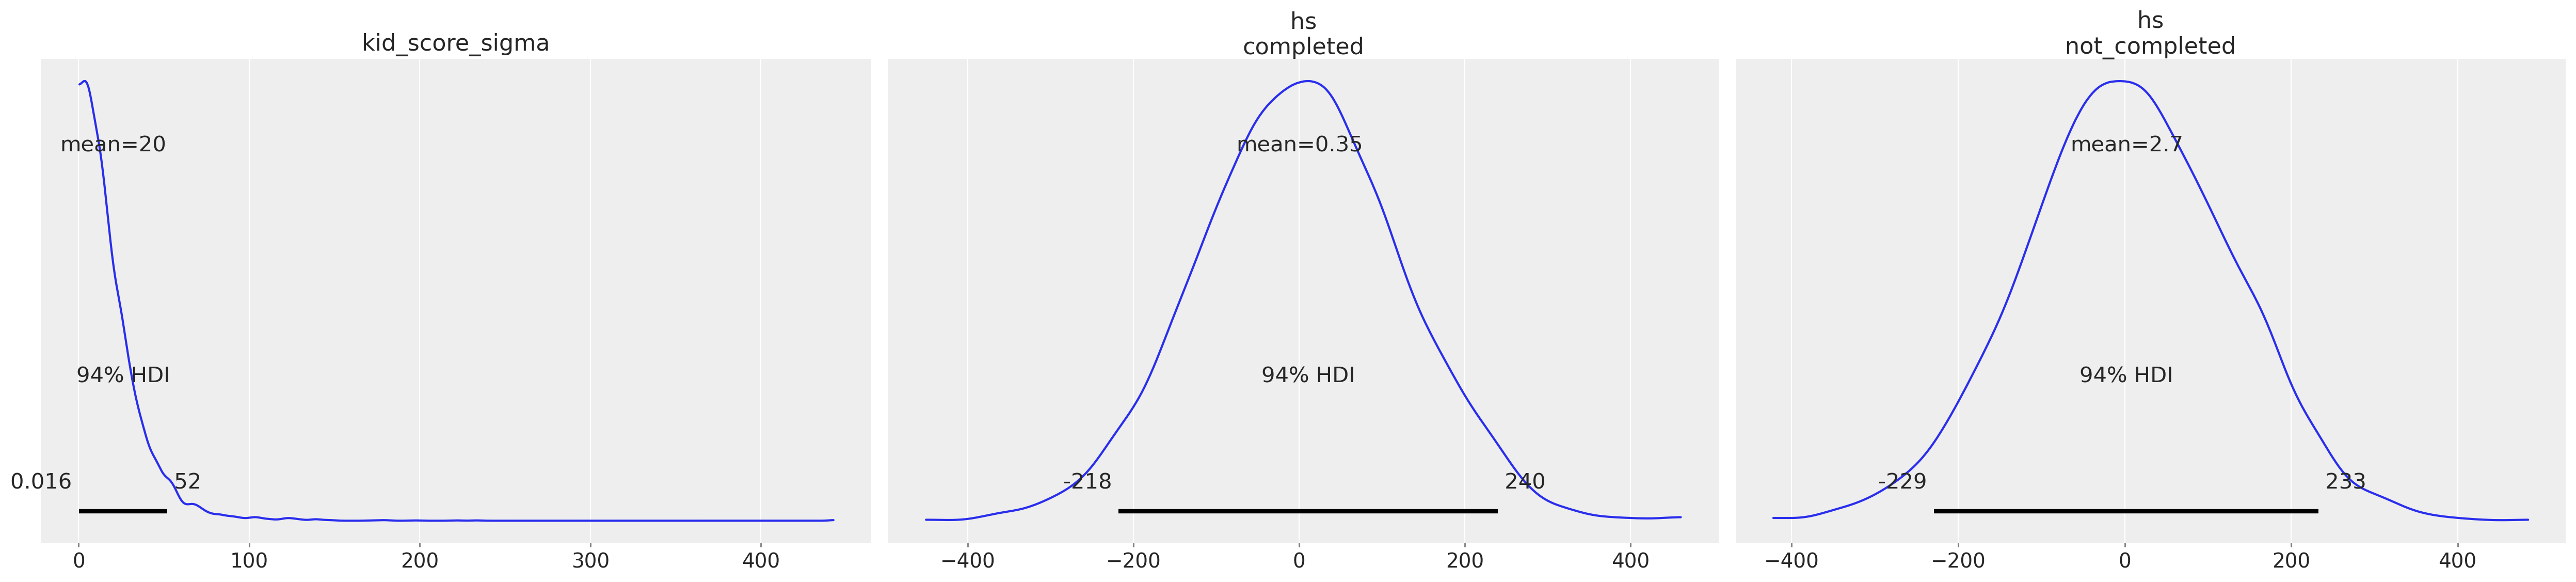

In [20]:
_ = mod_2.plot_priors()

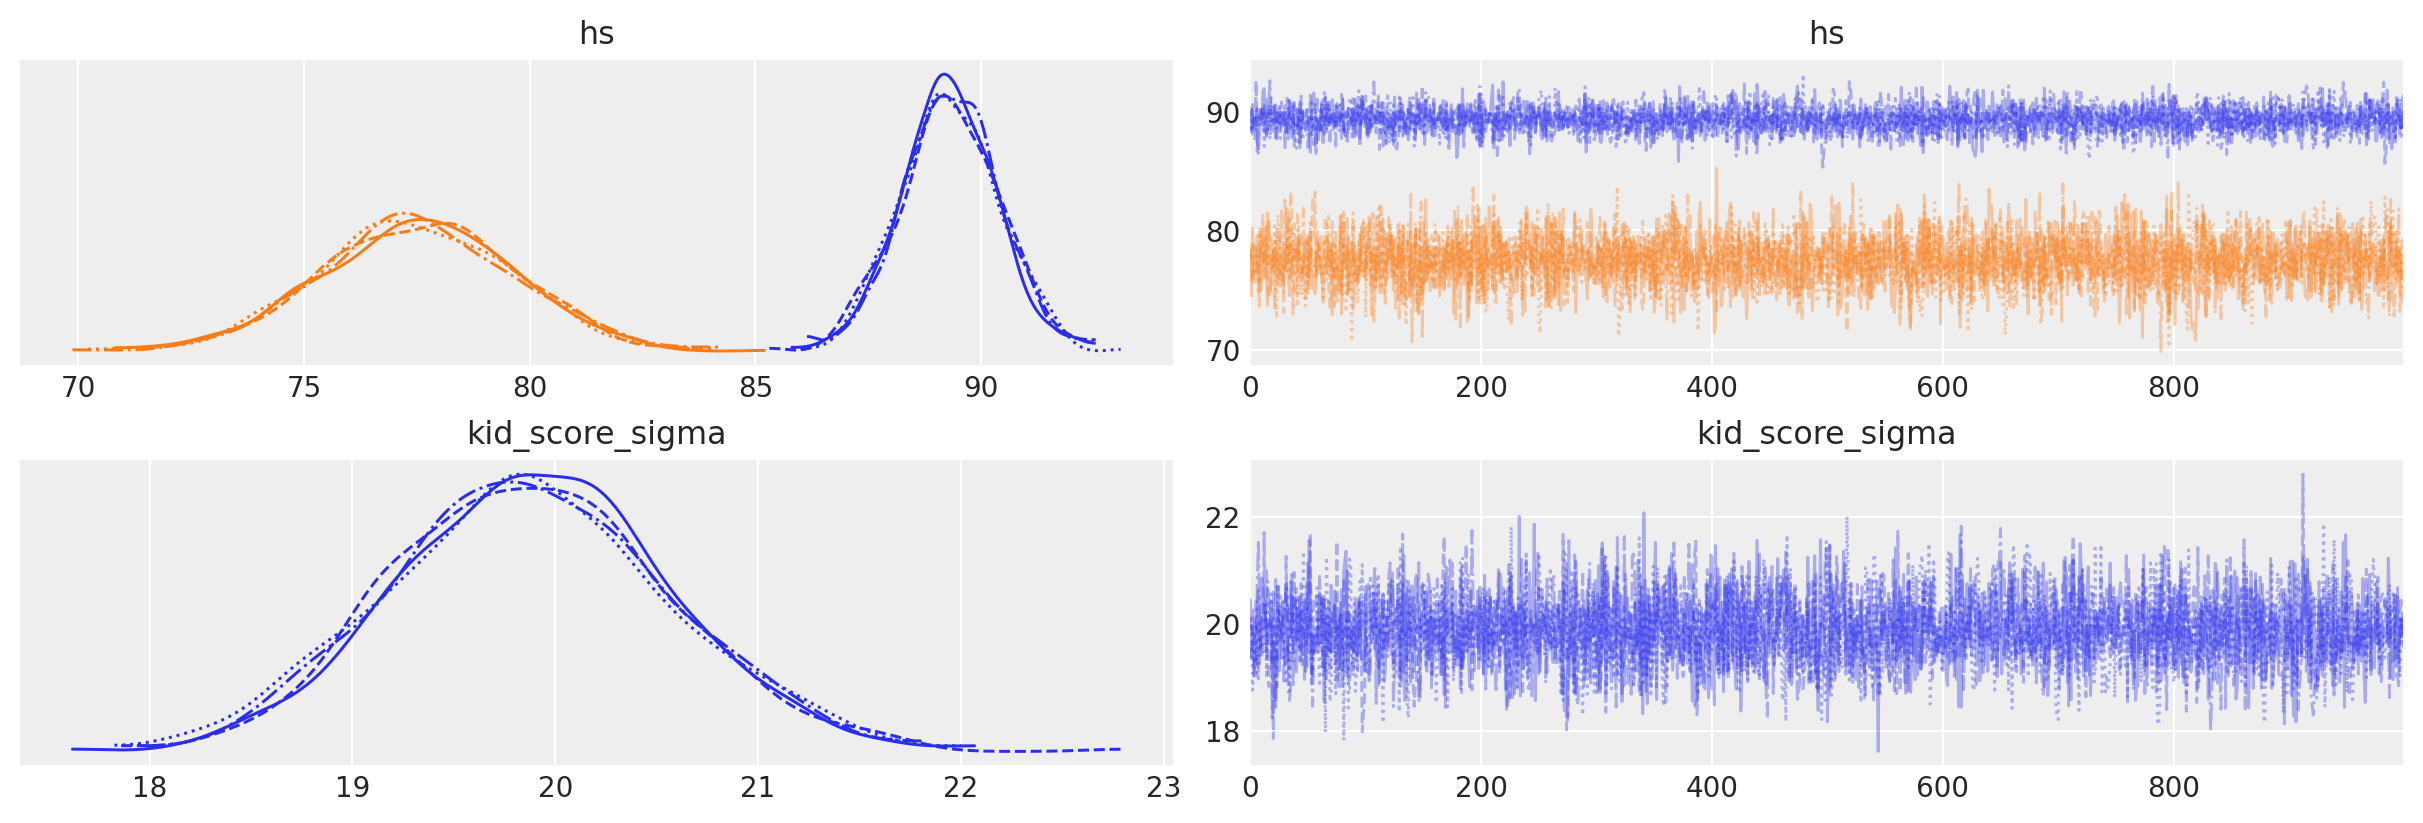

In [21]:
_ = az.plot_trace(results_2)

In [22]:
az.summary(results_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hs[completed],89.302,1.073,87.326,91.359,0.017,0.012,4154.0,2951.0,1.0
hs[not_completed],77.492,2.128,73.609,81.519,0.035,0.024,3788.0,2586.0,1.0
kid_score_sigma,19.877,0.675,18.633,21.169,0.010,0.007,4249.0,3079.0,1.0


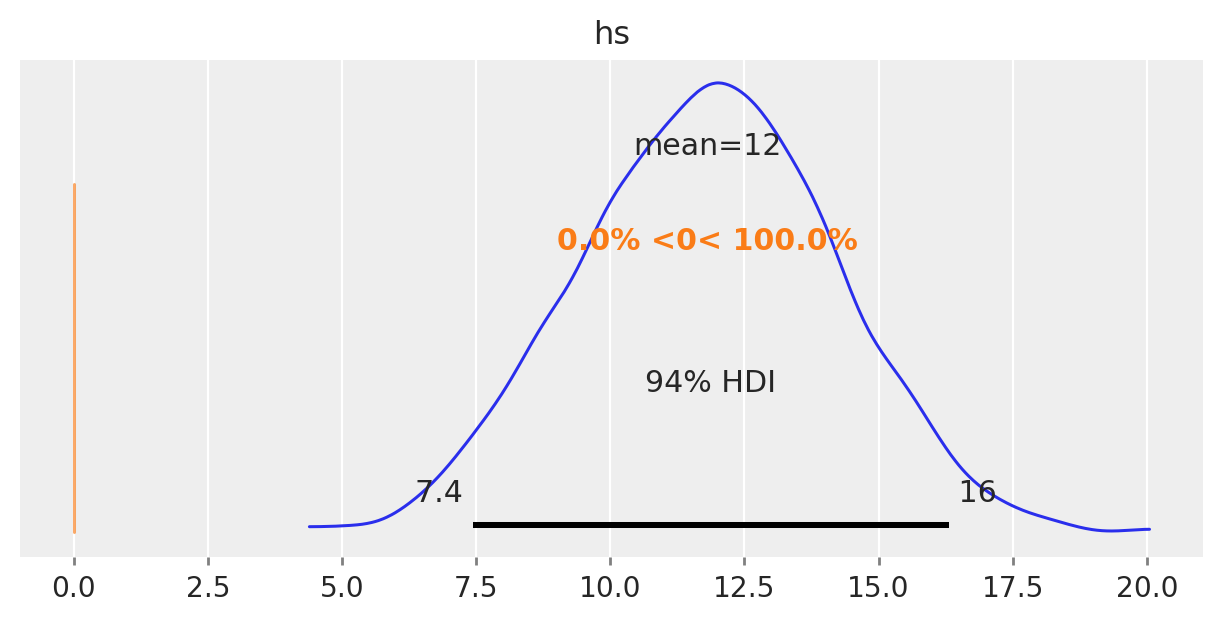

In [23]:
post_group = results_2.posterior["hs"]
diff = post_group.sel(hs_dim="completed") - post_group.sel(hs_dim="not_completed")
az.plot_posterior(diff, ref_val=0, figsize=(6, 3));

In [24]:
# Probabiliy that posterior is > 0
(post_group > 0).mean().item()

1.0

In [25]:
%load_ext watermark
%watermark -n -u -v -iv -w -m 

Last updated: Sun Jun 16 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

numpy     : 1.26.4
matplotlib: 3.8.4
pingouin  : 0.5.4
pandas    : 2.2.2
bambi     : 0.13.0
arviz     : 0.18.0

Watermark: 2.4.3

